# Práctica 2: Creación de visualización

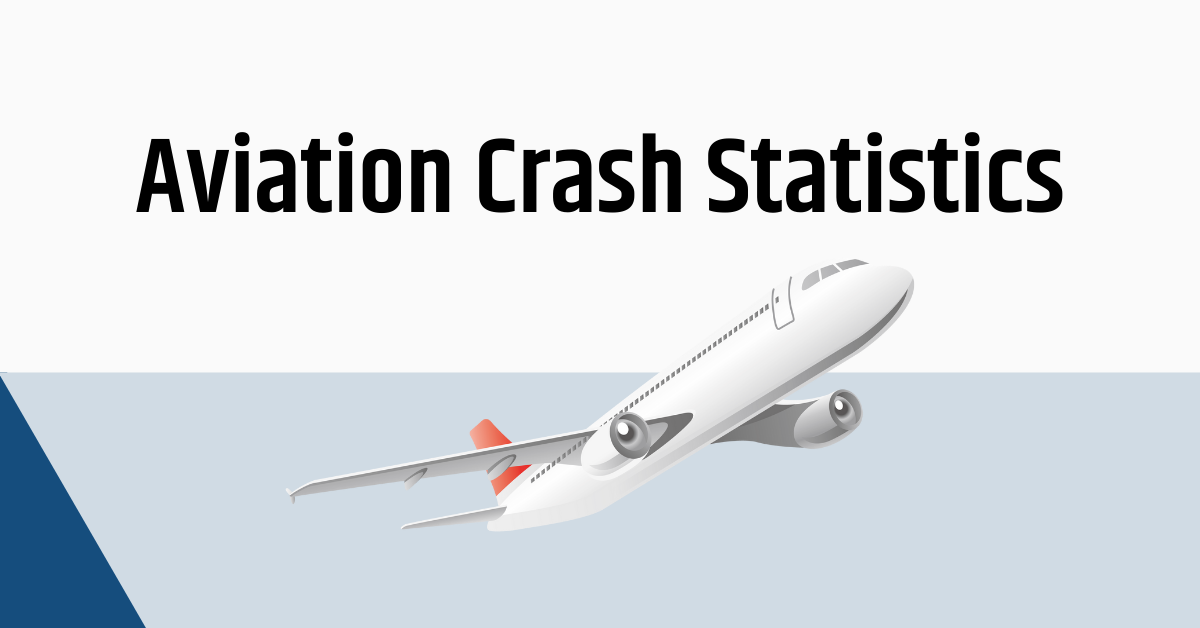

In [2]:
from IPython.display import Image
Image(filename='imgs/logo.png')

La base de datos de accidentes de aviación de la NTSB contiene información de 1962 y posteriores sobre accidentes de aviación civil dentro de los Estados Unidos, sus territorios y posesiones, y en aguas internacionales.

Más información del dataset: 

https://www.ntsb.gov/Pages/AviationQuery.aspx 

https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses

# Preguntas

· ¿Dónde fueron los accidentes?

· ¿Cuándo fueron los accidentes?

· ¿En qué fase fueron los accidentes?

· ¿Las condiciones meteorológicas han influenciado?

# Preprocesado (escondido)

Las siguientes celdas de código estan en modo *hide*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [2]:
df = pd.read_csv("AviationData.csv", encoding='cp1252')

In [3]:
df_duplicates = pd.concat(g for _, g in df.groupby('Event.Id') if len(g) > 1)

In [4]:
df.sort_values(by=['Event.Id','Accident.Number'], inplace=True)
df.drop_duplicates(subset='Event.Id',keep='last', inplace=True)

In [5]:
df['Weather.Condition'] = df['Weather.Condition'].replace('Unk','Unknown')
df['Weather.Condition'] = df['Weather.Condition'].replace('UNK','Unknown')
df['Registration.Number'] = df['Registration.Number'].replace('unk','Unknown')
df['Registration.Number'] = df['Registration.Number'].replace('unknown','Unknown')

In [6]:
df['Amateur.Built'] = df['Amateur.Built'].replace('N','No')
df['Amateur.Built'] = df['Amateur.Built'].replace('Y','Yes')

In [7]:
df['Make'] = df['Make'].str.lower()
df['Registration.Number'] = df['Registration.Number'].str.lower()
df['Airport.Name'] = df['Airport.Name'].str.lower()

In [8]:
df.drop(columns = ['Schedule', 'Air.carrier', 'FAR.Description', 'Aircraft.Category', 'Airport.Code', 'Airport.Name'], axis = 1, inplace = True)

In [9]:
index_nan = df[df['Total.Fatal.Injuries'].isna()].index
index_non_fatal = df[(df['Injury.Severity']=='Non-Fatal') | (df['Injury.Severity']=='Incident')].index
to_update = list(set(index_nan).intersection(index_non_fatal))
df.loc[to_update,'Total.Fatal.Injuries'] = 0.0

In [10]:
index_nan = df[df['Injury.Severity'].isna()].index
index_incident = df[df['Investigation.Type']=='Incident'].index
to_update = list(set(index_nan).intersection(index_incident))
df.loc[to_update,'Injury.Severity'] = "Incident"

In [11]:
index_non_fatal = df[df['Total.Fatal.Injuries']==0.0].index
index_nan = df[df['Injury.Severity'].isna()].index
to_update = list(set(index_nan).intersection(index_non_fatal))
df.loc[to_update,'Injury.Severity'] = "Non-Fatal"

In [12]:
df['Injury.Severity'] = df['Injury.Severity'].str.split('(').str[0]

In [13]:
df['Location'].fillna('Unknown',inplace=True)
df['Country'].fillna('Unknown',inplace=True)
df['Latitude'].fillna('Unknown',inplace=True)
df['Longitude'].fillna('Unknown',inplace=True)
df['Latitude'].fillna('Unknown',inplace=True)
df['Aircraft.damage'].fillna('Unknown',inplace=True)
df['Registration.Number'].fillna('Unknown',inplace=True)
df['Model'].fillna('Unknown',inplace=True)
df['Engine.Type'].fillna('Unknown',inplace=True)
df['Purpose.of.flight'].fillna('Unknown',inplace=True)
df['Weather.Condition'].fillna('Unknown',inplace=True)
df['Broad.phase.of.flight'].fillna('Unknown',inplace=True)
df['Report.Status'].fillna('Unknown',inplace=True)
df['Publication.Date'].fillna('Unknown',inplace=True)
df['Amateur.Built'].fillna('Unknown',inplace=True)
df['Make'].fillna('Unknown',inplace=True)                  

In [14]:
df['Event.Date'] = pd.to_datetime(df['Event.Date'])
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# ¿Dónde fueron los accidentes?

## Motivación

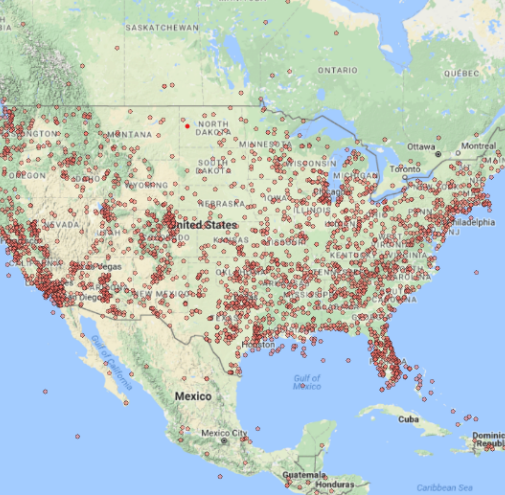

In [15]:
from IPython.display import Image
Image(filename='imgs/usa.png') 

## Plot 

92% del dataset son accidentes de USA. Para una mejor entendimiento trabajaré solo con estados de USA.

In [16]:
states = df[df['Country'] == 'United States']['Location'].str.slice(start=-2)
states = states.value_counts()
states = states[states > 15]

In [43]:
fig = px.choropleth(df,
                    locations=states.index, 
                    locationmode="USA-states", 
                    scope="usa",
                    color=states.values,
                    color_continuous_scale="Viridis_r",
                    labels={'color':'amount'}
                    )
fig.show()

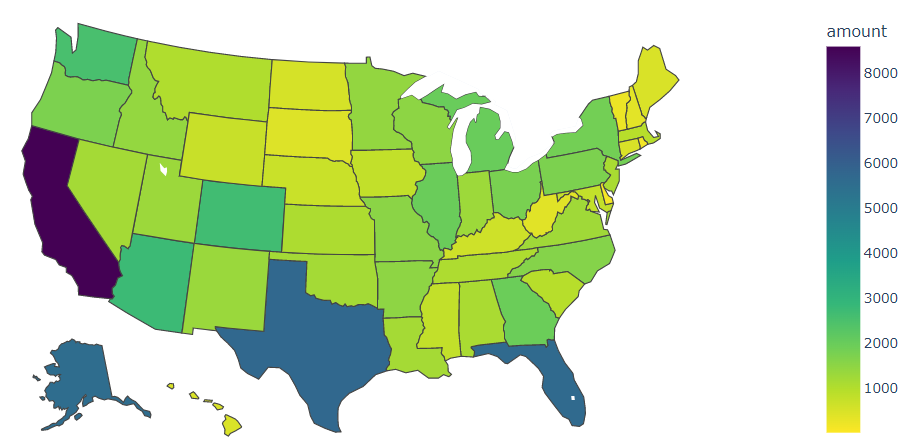

In [44]:
Image(filename='imgs/usa1.png') 

## ¿Cuándo suceden los accidentes?

In [21]:
import plotly.graph_objects as go

In [22]:
fig=go.Figure()

In [23]:
df_time = df[(df['Year'] >=1982) & (df['Year'] <=2021)]
accidents_by_year = df_time['Year'].value_counts().sort_index()
accidents_non_fatal = df_time[df_time['Injury.Severity'] == 'Non-Fatal']
accidents_non_fatal = accidents_non_fatal.groupby(['Year'])['Injury.Severity'].count()
accidents_fatal = df_time.groupby(['Year'])['Total.Fatal.Injuries'].sum()

In [24]:
fig.add_trace(go.Scatter(x=accidents_by_year.index,y=accidents_by_year.values,mode='lines',name="Accidents"))
fig.add_trace(go.Scatter(x=accidents_non_fatal.index,y=accidents_non_fatal.values,mode='lines',name="Non-Fatal Accidents"))
fig.add_trace(go.Scatter(x=accidents_fatal.index,y=accidents_fatal.values,mode='lines',name="Deaths",line=dict(color='lightgrey')))

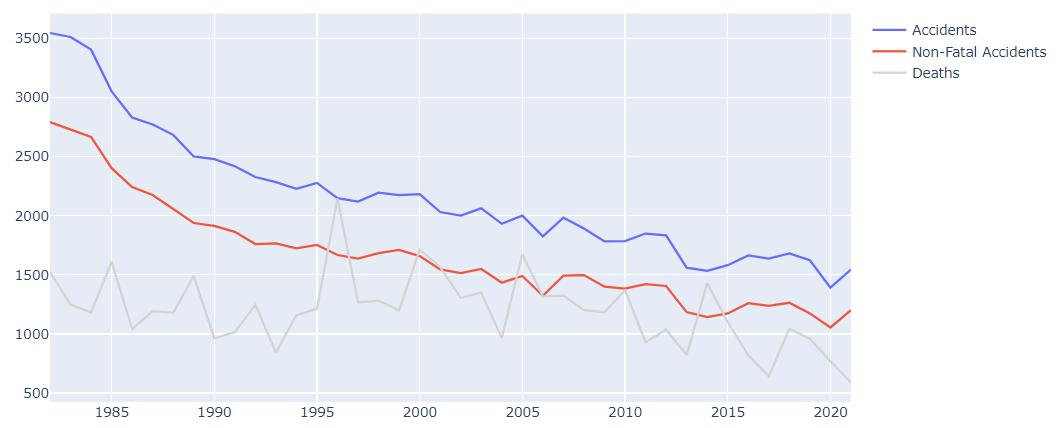

In [45]:
Image(filename='imgs/lineplot.png') 

In [25]:
df_time['Month'] = df_time['Month'].str.slice(start=0, stop=3)

In [46]:
fig = go.Figure(data=[go.Histogram(x=df_time['Month'])])
fig.update_layout(title="Accidents by Months",xaxis_title="Months",yaxis_title="Count")
fig.show()

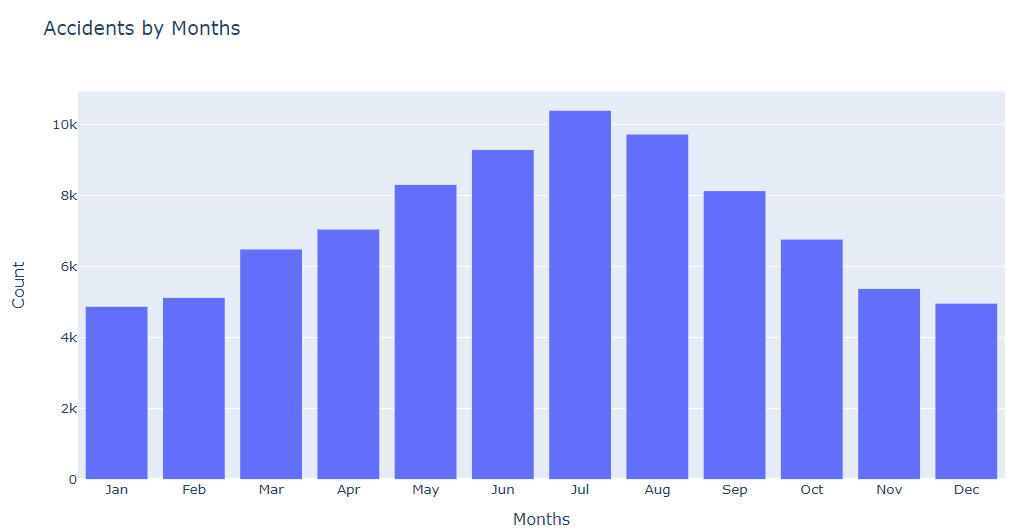

In [47]:
Image(filename='imgs/months.png') 

In [28]:
df_time['Day'] = df_time['Day'].str.slice(start=0, stop=3)
df_time['Day'][45497] = 'Mon'
df_time['Day'][45500] = 'Wed'
df_time['Day'][87278] = 'Sun'
df_time['Day'][45569] = 'Fri'
df_time['Day'][45543] = 'Sat'
df_time['Day'][45527] = 'Sun'

In [29]:
fig = go.Figure(data=[go.Histogram(x=df_time['Day'])])
fig.update_layout(title="Accidents by Days",xaxis_title="Days",yaxis_title="Count")
fig.show()

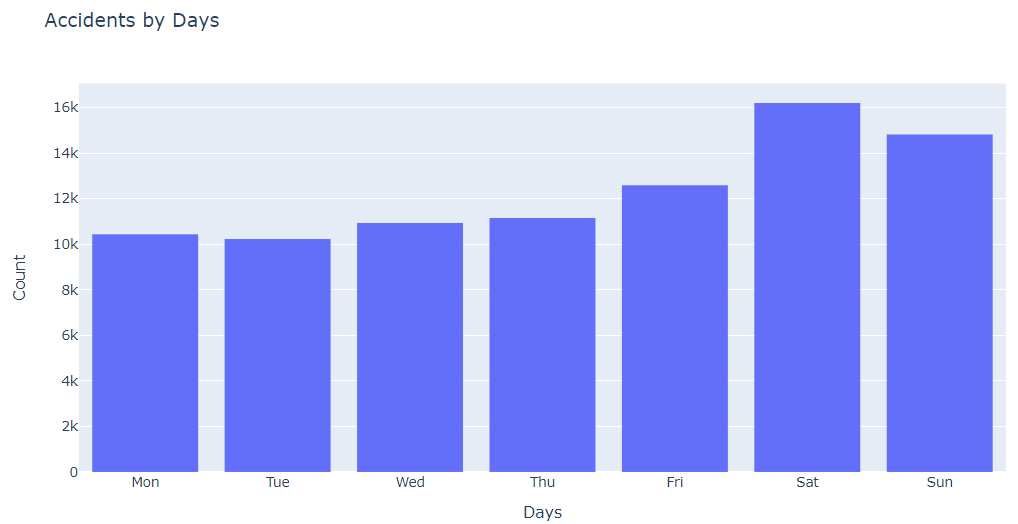

In [48]:
Image(filename='imgs/days.png') 

· Número de accidentes se ha reducido durante los años

· Mayoría de accidentes en verano (May-Sep)

· Mayoría de accidentes en fines de semana

## ¿En qué fase succeden los accidentes?

In [37]:
df_time['Broad.phase.of.flight'][45497] = 'Landing'
df_time['Broad.phase.of.flight'][45531] = 'Takeoff'
df_time['Broad.phase.of.flight'][45480] = 'Cruise'
df_time['Broad.phase.of.flight'][45500] = 'Maneuvering'
df_time['Broad.phase.of.flight'][45503] = 'Approach'

In [38]:
fig = go.Figure(data=[go.Histogram(x=df_time['Broad.phase.of.flight'][df_time['Broad.phase.of.flight']!='Unknown'])])
fig.update_layout(title="Accidents by Phase",xaxis_title="Phases",yaxis_title="Count")
fig.show()

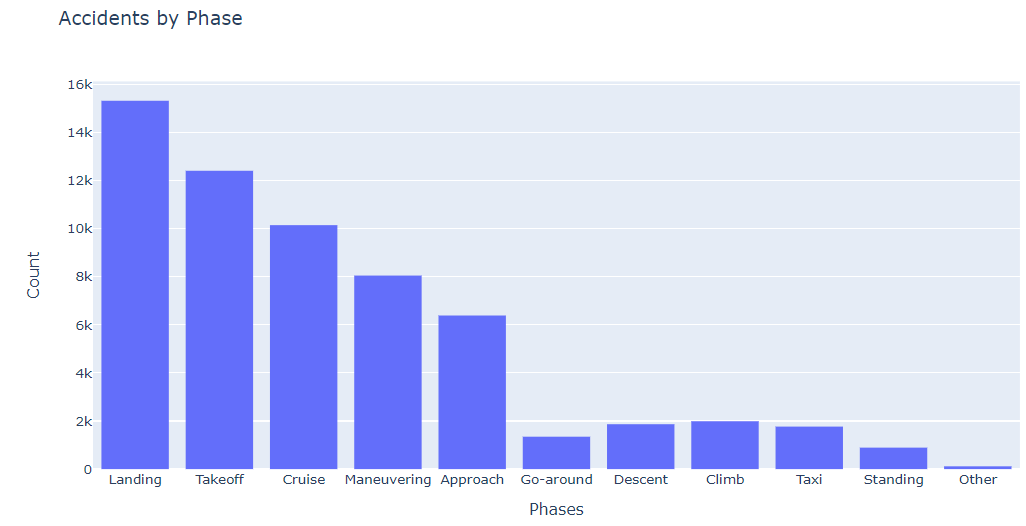

In [50]:
Image(filename='imgs/phase.png') 

## Efecto de las condiciones metereológicas

In [39]:
fig = go.Figure(data=[go.Histogram(x=df['Weather.Condition'][df['Weather.Condition'] != 'Unknown'])])
fig.update_layout(title="Accidents by Weather Conditions",xaxis_title="Phases",yaxis_title="Count")
fig.show()

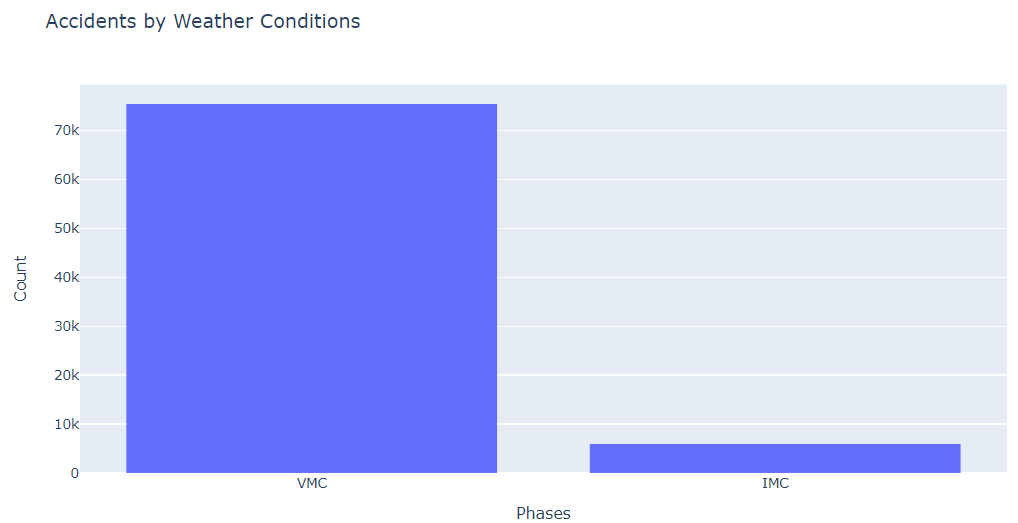

In [51]:
Image(filename='imgs/weather.png') 

In [40]:
df['Weather.Condition'][df['Weather.Condition'] == 'VMC'] = 0
df['Weather.Condition'][df['Weather.Condition'] == 'IMC'] = 1
df['Weather.Condition'][df['Weather.Condition'] == 'Unknown'] = 2

In [41]:
df['Weather.Condition'] = df['Weather.Condition'].astype(str).astype(float)

<AxesSubplot:>

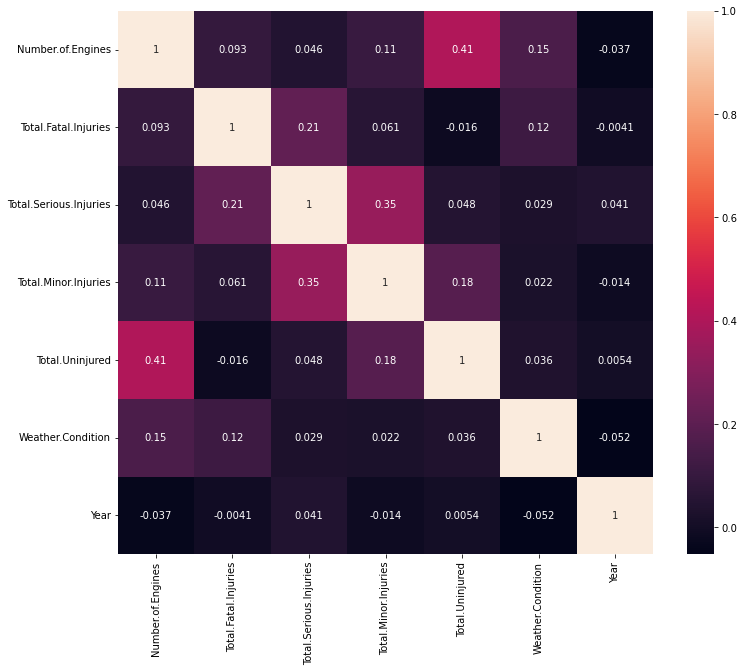

In [42]:
plt.figure(figsize=(12,10))
sns.heatmap(df[df['Weather.Condition'] != 2].corr(), annot = True)

· Accidentes disminuyeron un 2% cada año

· Mayoría de accidentes entre Mayo-Septiembre (Verano)

· Mayoría de accidentes el Sábado o Domingo (Fin de semana)

· Mayoría de accidentes durante aterrizaje o despegue

· 92% del dataset es de USA

· El estado con más accidentes es California